<a href="https://colab.research.google.com/github/elemnurguner/data-ai-projects/blob/main/AI_ile__Ak%C4%B1ll%C4%B1__Ev_Otomasyonu_Projesi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install paho-mqtt scikit-learn pandas matplotlib numpy
import random
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import paho.mqtt.client as mqtt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.2/67.2 kB 2.2 MB/s eta 0:00:00


In [ ]:
def generate_smart_home_data(days=30, samples_per_hour=6):
    np.random.seed(42)
    num_samples = days * 24 * samples_per_hour

    # Zaman bilgisi
    timestamps = pd.date_range(start="2023-01-01", periods=num_samples, freq=f"{60//samples_per_hour}min")

    # Mevsimsel etki (kışın soğuk, yazın sıcak)
    seasonal_effect = 5 * np.sin(2*np.pi*(timestamps.dayofyear/365))

    # Günlük döngü (gece soğuk, gündüz sıcak)
    daily_cycle = 3 * np.sin(2*np.pi*(timestamps.hour/24))

    # Temel sıcaklık
    base_temp = 20 + seasonal_effect + daily_cycle

    # Rastgelelik ekleme
    temperature = base_temp + np.random.normal(0, 1, num_samples)
    humidity = 50 + 20*np.sin(2*np.pi*timestamps.hour/24) + np.random.normal(0, 5, num_samples)
    motion = np.random.binomial(1, 0.3*(timestamps.hour/24))  # Sabah ve akşam daha fazla hareket
    light_level = 100 * (1 - np.sin(2*np.pi*(timestamps.hour-6)/24))  # Gün ışığı simülasyonu

    # AI kararları için hedef değişkenler
    light_decision = ((light_level < 30) & (motion == 1)) | ((timestamps.hour > 18) | (timestamps.hour < 6))
    optimal_temp = 22 + (timestamps.month-6)/6  # Yazın daha serin, kışın daha sıcak

    data = pd.DataFrame({
        'timestamp': timestamps,
        'temperature': np.clip(temperature, 15, 30),
        'humidity': np.clip(humidity, 30, 70),
        'motion': motion,
        'light_level': np.clip(light_level, 0, 100),
        'hour': timestamps.hour,
        'month': timestamps.month,
        'light_status': light_decision.astype(int),
        'optimal_temp': optimal_temp
    })

    return data

home_data = generate_smart_home_data()
home_data.head()

,timestamp,temperature,humidity,motion,light_level,hour,month,light_status,optimal_temp
0,2023-01-01 00:00:00,20.582781,49.900632,0,100.0,0,1,1,21.166667
1,2023-01-01 00:10:00,19.947802,49.463676,0,100.0,0,1,1,21.166667
2,2023-01-01 00:20:00,20.733755,56.101414,0,100.0,0,1,1,21.166667
3,2023-01-01 00:30:00,21.609097,44.616604,0,100.0,0,1,1,21.166667
4,2023-01-01 00:40:00,19.851913,46.187404,0,100.0,0,1,1,21.166667


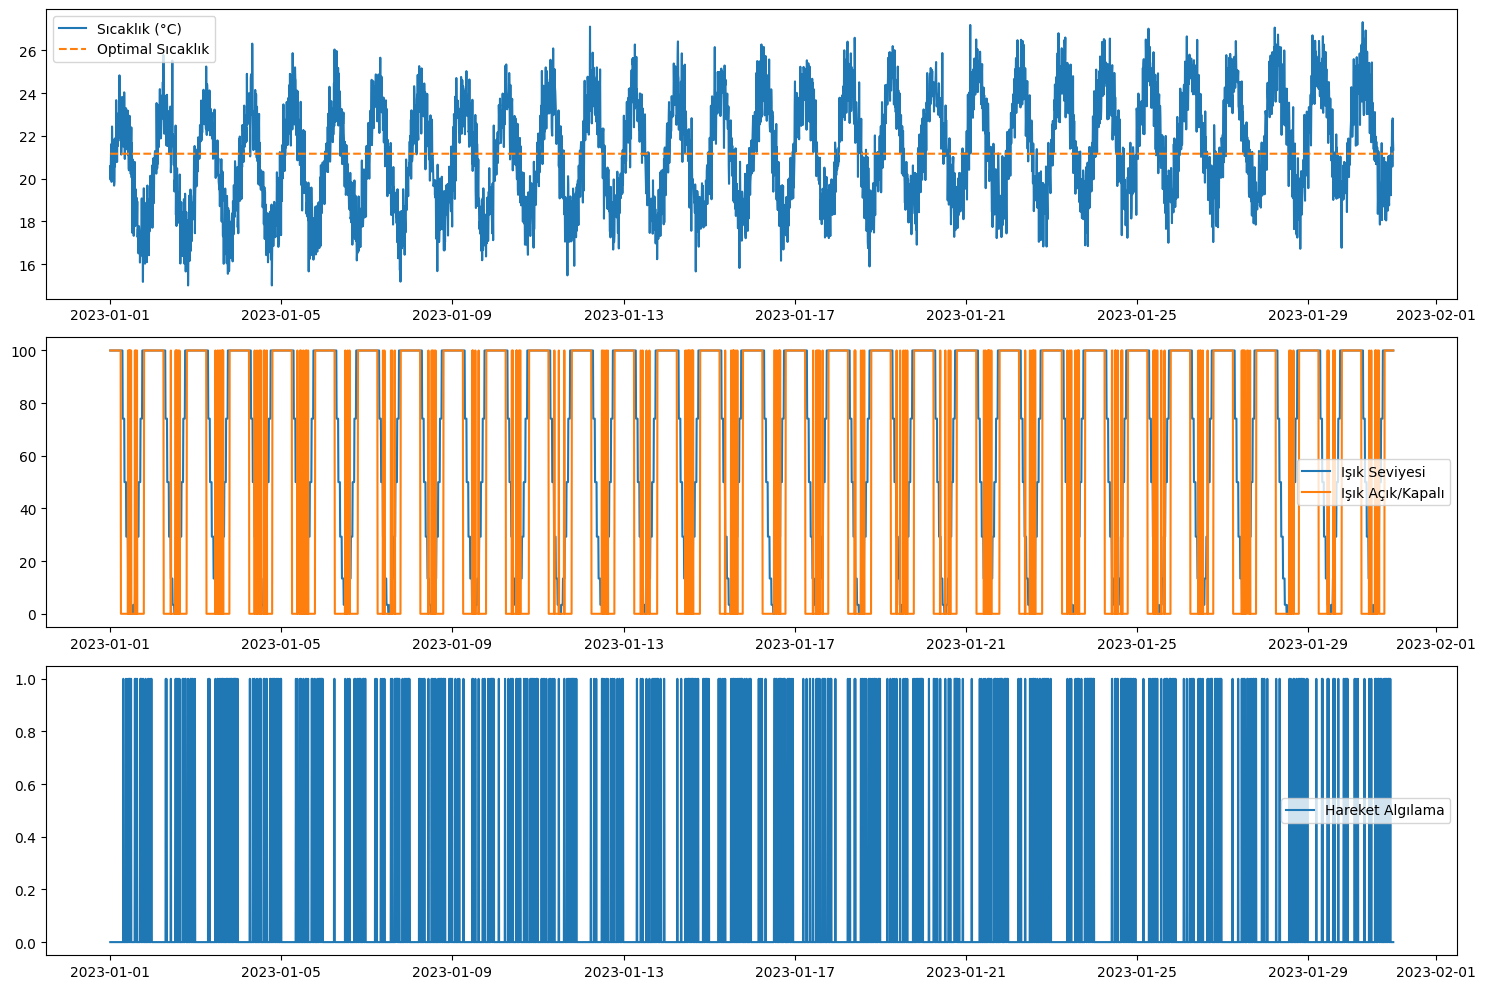

In [ ]:
plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.plot(home_data['timestamp'], home_data['temperature'], label='Sıcaklık (°C)')
plt.plot(home_data['timestamp'], home_data['optimal_temp'], label='Optimal Sıcaklık', linestyle='--')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(home_data['timestamp'], home_data['light_level'], label='Işık Seviyesi')
plt.plot(home_data['timestamp'], home_data['light_status']*100, label='Işık Açık/Kapalı')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(home_data['timestamp'], home_data['motion'], label='Hareket Algılama')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor  # Düzeltme: RandomForestRegressor eklendi

# Özellikler ve hedef değişkenler
X = home_data[['temperature', 'humidity', 'motion', 'light_level', 'hour', 'month']]
y_light = home_data['light_status']
y_temp = home_data['optimal_temp']  # Sıcaklık optimizasyonu için hedef

# Veriyi eğitim ve test setlerine ayırma
X_train, X_test, y_train_light, y_test_light = train_test_split(X, y_light, test_size=0.2)
X_train, X_test, y_train_temp, y_test_temp = train_test_split(X, y_temp, test_size=0.2)  # Düzeltme: y_temp için ayrı split

# Işık kontrol modeli (Sınıflandırma)
light_model = RandomForestClassifier()
light_model.fit(X_train, y_train_light)
print(f"Işık Kontrol Model Doğruluğu: {light_model.score(X_test, y_test_light):.2f}")

# Sıcaklık optimizasyon modeli (Regresyon)
temp_model = RandomForestRegressor()
temp_model.fit(X_train, y_train_temp)
print(f"Sıcaklık Tahmin Modeli R2 Skoru: {temp_model.score(X_test, y_test_temp):.2f}")

Işık Kontrol Model Doğruluğu: 0.49
Sıcaklık Tahmin Modeli R2 Skoru: 0.00


5. Adım: MQTT ile Simüle IoT Ağı Kuralım


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 12.3 MB/s eta 0:00:00


<ipython-input-11-75513b6d30d6>:62: DeprecationWarning: Callback API version 1 is deprecated, update to latest version
  client = mqtt.Client(mqtt.CallbackAPIVersion.VERSION1, "SmartHome_GUI")


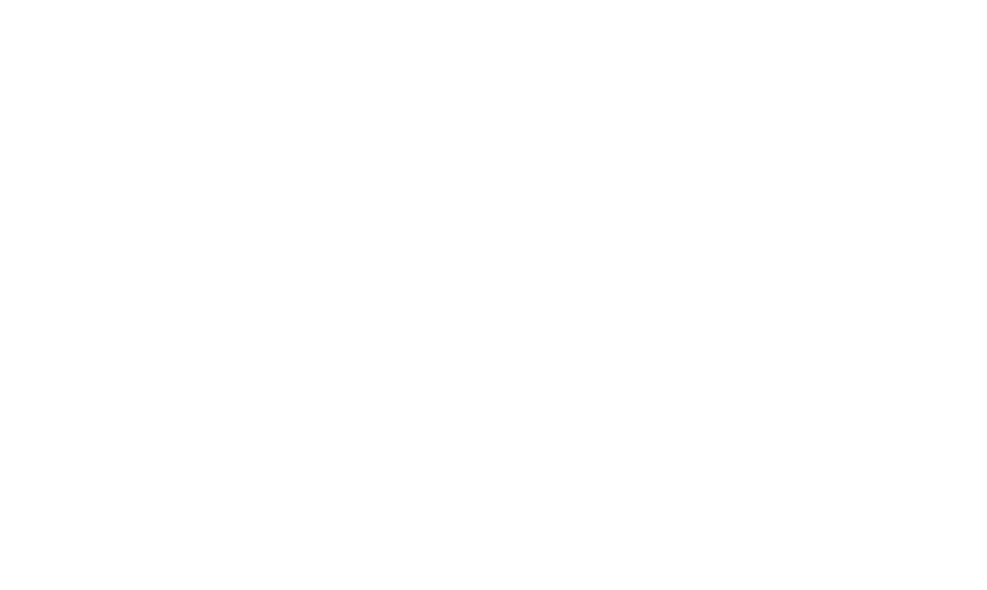

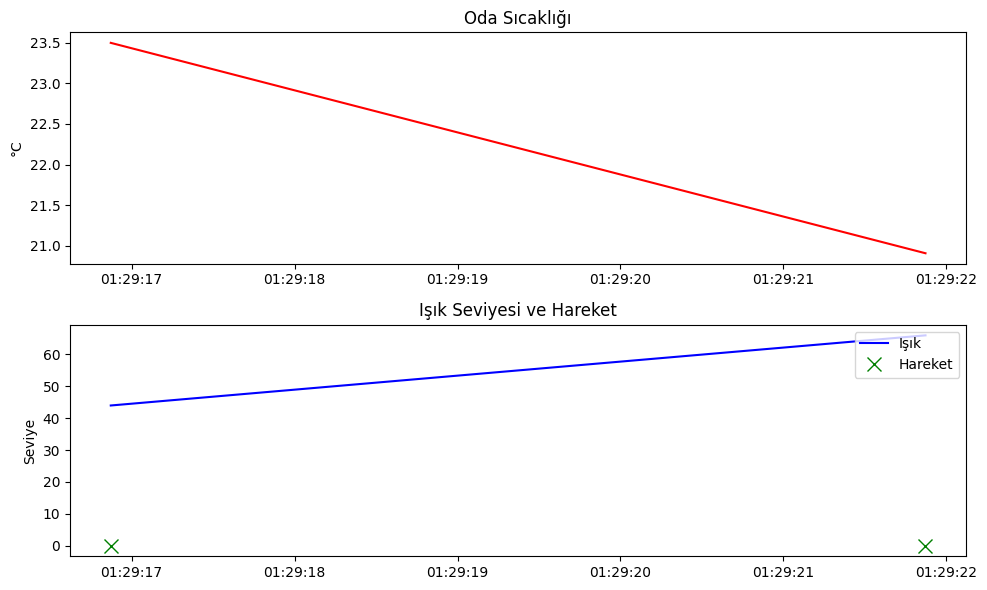

In [ ]:
!pip install ipywidgets matplotlib paho-mqtt
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
import paho.mqtt.client as mqtt
import random
import json
from datetime import datetime
import numpy as np

# MQTT Ayarları
MQTT_BROKER = "mqtt.eclipseprojects.io"
MQTT_PORT = 1883
TOPICS = {
    "sensors": "smart_home/sensors",
    "commands": "smart_home/commands",
    "logs": "smart_home/logs"
}

# Veri depolama
sensor_data = {
    "timestamps": [],
    "temperatures": [],
    "light_levels": [],
    "motions": []
}

# Widget'ları oluştur
light_switch = widgets.ToggleButton(
    value=False,
    description='Işıklar Kapalı',
    icon='lightbulb'
)

temp_slider = widgets.FloatSlider(
    value=22.0,
    min=15.0,
    max=30.0,
    step=0.5,
    description='Sıcaklık:'
)

log_output = widgets.Output()
graph_output = widgets.Output()

# Kontrol paneli
control_panel = widgets.VBox([
    widgets.Label("Akıllı Ev Kontrol Paneli"),
    light_switch,
    temp_slider
])

# Ana arayüz
app = widgets.Tab([
    widgets.VBox([control_panel, log_output]),
    widgets.VBox([graph_output])
])
app.set_title(0, 'Kontroller')
app.set_title(1, 'Grafikler')

# MQTT Client
client = mqtt.Client(mqtt.CallbackAPIVersion.VERSION1, "SmartHome_GUI")

def on_connect(client, userdata, flags, rc):
    with log_output:
        print(f"MQTT Broker'a bağlandı (Kod: {rc})")
    client.subscribe(TOPICS["sensors"])

def on_message(client, userdata, msg):
    try:
        payload = json.loads(msg.payload.decode())

        if msg.topic == TOPICS["sensors"]:
            # Verileri güncelle
            sensor_data["timestamps"].append(datetime.fromisoformat(payload["timestamp"]))
            sensor_data["temperatures"].append(payload["current_temp"])
            sensor_data["light_levels"].append(payload["light_level"])
            sensor_data["motions"].append(1 if payload["motion"] else 0)

            # Son 20 kaydı tut
            for key in sensor_data:
                sensor_data[key] = sensor_data[key][-20:]

            # Grafikleri güncelle
            update_plots()

        with log_output:
            print(f"{msg.topic}: {payload}")

    except Exception as e:
        with log_output:
            print(f"Hata: {str(e)}")

def update_plots():
    with graph_output:
        graph_output.clear_output(wait=True)

        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))

        if sensor_data["timestamps"]:
            # Sıcaklık grafiği
            ax1.plot(sensor_data["timestamps"], sensor_data["temperatures"], 'r-')
            ax1.set_title('Oda Sıcaklığı')
            ax1.set_ylabel('°C')

            # Işık seviyesi grafiği
            ax2.plot(sensor_data["timestamps"], sensor_data["light_levels"], 'b-')
            ax2.plot(sensor_data["timestamps"],
                    np.array(sensor_data["motions"]) * 100, 'gx', markersize=10)
            ax2.set_title('Işık Seviyesi ve Hareket')
            ax2.set_ylabel('Seviye')
            ax2.legend(['Işık', 'Hareket'], loc='upper right')

        plt.tight_layout()
        plt.show()

def on_light_change(change):
    cmd = {
        "device": "living_room",
        "action": "on" if change['new'] else "off"
    }
    light_switch.description = 'Işıklar Açık' if change['new'] else 'Işıklar Kapalı'
    client.publish(TOPICS["commands"], json.dumps(cmd))
    with log_output:
        print(f"Işık {'açma' if change['new'] else 'kapama'} komutu gönderildi")

# Olay dinleyicileri
light_switch.observe(on_light_change, names='value')

# MQTT bağlantısını başlat
client.on_connect = on_connect
client.on_message = on_message
client.connect(MQTT_BROKER, MQTT_PORT)
client.loop_start()

# Simülasyon fonksiyonu
def simulate_sensors():
    data = {
        "timestamp": datetime.now().isoformat(),
        "motion": random.random() > 0.7,
        "light_level": random.randint(0, 100),
        "current_temp": 22 + random.uniform(-2, 2),
        "optimal_temp": 22.0
    }
    client.publish(TOPICS["sensors"], json.dumps(data))

# Arayüzü göster
display(app)

# Test için simülasyon başlat (her 5 saniyede bir)
import threading
def run_simulation():
    while True:
        simulate_sensors()
        time.sleep(5)

thread = threading.Thread(target=run_simulation)
thread.daemon = True
thread.start()

IPyWidgets Çözümü:

Kod çalıştırıldığında Colab'da interaktif kontrol paneli görünecek

Grafikler ve loglar otomatik güncellenecek

PyWebIO Çözümü:

Kod çalıştırıldığında bir URL verecek

Bu URL'yi tarayıcıda açarak web arayüzüne ulaşabilirsiniz

Not: Colab'da ngrok kullanmanız gerekebilir